# Broker

In [1]:

sol_order = ['age','sex','death_rate','tampone','PCR','LDH','WBC','D_dimero','linfociti_percentage','neutrofili_su_linfociti'] 

#define a constant for death rate (?)
DEATH_RATE = 0.5
#options for single values
value_options={'days_v':int(),'pred':[],'is_changed':True}
               
#dictionary where we find single values which we need to publish 
values = dict()
for opt in value_options:
  values[opt[0]] = opt[1]

#OPTIONS FOR SLIDER AND DROPDOWNS
#(label name,min,max,feature name,i -> IntegerSlider || f-> FloaterSlider)
slider_options = [
          ('età',18,100,'age','i'),
          ('PCR',0,500,'PCR','f'),
          ('LDH',100,1000,'LDH','f'),
          ('WBC',0,400,'WBC','f'),
          ('D-Dimero',100,30000,'D_dimero','f'),
          ('linfociti (%)',1,12,'linfociti_percentage','f'),
          ('neutrofili/linfociti',0,150,'neutrofili_su_linfociti','f'),
          ('death_rate',0,1,'death_rate','f')
          ]

#(label name,options,feature name,processed values)
dropdown_options = [
          ['risultato tampone',['positivo','debolmente positivo','negativo','non valido'],'tampone',['positivo','debolmente positivo','negativo','non_valido']],#[2,1,0,-1]],                   
          ['sesso',['Maschio','Femmina'],'sex',['M','F']] 
         ]

#values for sliders and dropdowns 
# slider_values[name_of_slider] = value
#dropdown_values[name_of_dropdown] = value
slider_values = dict()
dropdown_values = dict()
for opt in slider_options:
 # print(opt)
  if opt[4] == 'f': 
   slider_values[str(opt[0])] = float()
  else:
   slider_values[str(opt[0])] = int()
for opt in dropdown_options:
  dropdown_values[str(opt[0])] = ''

# We define a dict of object wich is called when there's a change in a group of variables
sub_dashboard=dict()
sub_days=dict()
sub_pred=dict()
cells=dict()

# Import and utils

In [2]:
import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display,clear_output
import numpy as np
import pandas as pd
import dill
import os
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt


def space():
  return widgets.HTML('<br>')

def line():
  return widgets.HTML('<hr>')

def see_values():
  print(slider_values)
  print(dropdown_values)
  print(values)
  print(sub_dashboard)
  print(sub_days)

def change_value(name_variable,value,dict_to_change,subscribers):
  dict_to_change[name_variable] = value
  #we define mathod update wich update all the variables in the subscriber
  #post method on the contrary change value in the broker
  for k in subscribers.keys():
    subscribers[k].update()   

def subscribe(obj,sub):
  #sub.append(obj) 
  sub[id(obj)]=obj

# all cells must have compose method to visualize
def see(obj,compose=True):
  if compose:
   display(widgets.VBox([space(),obj.compose()]))   
  else:
   display(widgets.VBox([space(),obj]))   

def get_x(sol_order,slider_options,drodown_options,slider_values,dropdown_values):
    #Preprocessing data (we adjust only dropdown values) and order features
    x=dict()
    for op in slider_options:
        value = slider_values[op[0]]
        for feat in sol_order:
            if feat == op[3]:
                x[feat] = value
        
    for op in dropdown_options:
        for i in range(len(op[1])):
            #print(op[1][i],dropdown_values[op[0]],dropdown_values)
            if op[1][i] == dropdown_values[op[0]]:
                value = op[3][i]
                print(value)
                for feat in sol_order:
                    print(feat,op[2])
                    if feat == op[2]:
                        x[feat] = value
    
    #check if prediction is corretct, if for some reason method not work return False
    if len(list(x.keys())) != len(sol_order):
     return False
    
    #order the vector
    p=dict()
    for feat in sol_order:
        p[feat]=[x[feat]]
        
    X=pd.DataFrame.from_dict(p)
    
    return X
    

In [3]:
# class wictch contains all informations about model 
# DataModel object is subscribed to sub_days so we recycle upload strategy used for widgets
class DataModel():
        
    def update(self):
       self.solution=self.get_solution(value_options['days_v'])
       print(self.solution)
    
    def get_model_id(self,day):
       return self.day_model[str(day)] + '_iterativeimputer_randomsearch_10'

    def get_dataset_id(self,day):
       return self.day_data[str(day)] + '_all_patients_numerical_simplified_3plus7_features'
    
    def get_solution(self,day):
       return self.tourney.classification_matches[(self.get_dataset_id(2)),self.get_model_id(2)].results.solution
    
    def load_classification_tourney(self): 
      filepath = 'classification_tourney_mortality_risk_covid19_all_patients_simplified.dill'
      if not os.path.exists(filepath):   
       !tar -xvzf mdl.tar.gz   
      dill_file = open(filepath, 'rb')
      classification_tourney = dill.load(dill_file)
      dill_file.close()
      return classification_tourney
    
    def predict(self):
     if self.solution == None:
        return
     return self.solution.predict(self.X),self.solution.predict_proba(self.X)

        
        
    def __init__(self):
        
     self.tourney = self.load_classification_tourney()
     self.X = None
     #model to use for each dataset. They are been chosen especially for recall and f2 score 
     self.day_model={'2':'XGBC','4':'XGBC','6':'LGBM','8':'LGBM','10':'XGBC','end':'XGBC'}
     self.day_data={'2':'2days','4':'4days','6':'6days','8':'8days','end':'end'}
     self.solution = self.get_solution(value_options['days_v'])   
    
###################################################################################################

m = DataModel()
subscribe(m,sub_days)


# Cells

In [4]:
class Days_toggle():
    
 def post_day(self,change):
   change_value('days_v',self.days.value,value_options,sub_days) 
  
 def __init__(self):
  #self.val = values
  #self.sub_days = sub_days
  self.days = widgets.ToggleButtons(options=['2', '4', '6','8','10','end'],layout=widgets.Layout(width='95%'))
  self.l_day = widgets.Label(value='giorni ospedalizzazione',layout=widgets.Layout(display="flex", justify_content="center"))
  self.days.observe(self.post_day, names='value')
  

 def compose(self):
  return widgets.VBox([self.l_day,self.days])

########################################################################################################################

d = Days_toggle()
#display(widgets.VBox([space(),d.compose()]))
see(d)


In [5]:

class Dashboard:
 def post_dashboard_values(self,change=None):
  for w in self.sliders:
    change_value(w['l_f'].value,w['widget'].value,slider_values,sub_dashboard)
  for w in self.dropdowns:
    change_value(w['l_f'].value,w['widget'].value,dropdown_values,sub_dashboard)
  value_options['is_changed'] = True

 def null_variation(self,change):
  for w in self.sliders:
    w['widget'].value = w['widget'].min
  self.post_dashboard_values() 

 def __init__(self,slider_options,dropdown_options):
  
  #self.sub_dashboard=sub_dashboard
  self.sliders = list()
  self.dropdowns = list() 
  #self.slider_val = slider_values
  #self.dropdown_val = dropdown_values

  self.b_reset = widgets.Button(description='Azzera Valori')

  for op in slider_options:
   f = dict()
   if op[4]=='f':
    f['widget'] = widgets.FloatSlider(min=op[1],max=op[2])
   else:
    f['widget'] = widgets.IntSlider(min=op[1],max=op[2]) 
   f['l_f'] = widgets.Label(value=op[0])
   #f['p_f'] = widgets.Label()
   self.sliders.append(f)

  for op in dropdown_options:
   f = dict()
   f['widget'] = widgets.Dropdown(options=op[1])
   f['l_f']= widgets.Label(value=op[0])
   #f['p_f'] = widgets.Label()
   self.dropdowns.append(f)

  for w in self.sliders + self.dropdowns:
   w['widget'].observe(self.post_dashboard_values, names='value')

  self.b_reset.on_click(self.null_variation)        

 def compose(self): 
  cells = list()
  for s in self.sliders + self.dropdowns:
   cells.append(widgets.VBox([s['l_f'],s['widget']]))
        
   columns = [widgets.VBox(cells[:3]),
             widgets.VBox(cells[3:6]),
             widgets.VBox(cells[6:8]), 
             widgets.VBox(cells[8:]),
             widgets.VBox([self.b_reset],layout=widgets.Layout(display="flex", justify_content="flex-end"))]


  return widgets.VBox([space(),
                       widgets.HBox(columns,layout=widgets.Layout(display="flex", justify_content="center")),
                       space()],layout=widgets.Layout(border='1px solid grey'))

######################################################################################################## 

dash = Dashboard(slider_options,dropdown_options)
cell_dashboard = dash.compose()
see(dash)


In [6]:
class SendButton():
  
 def post(self,change):   
  x=get_x(sol_order,slider_options,dropdown_options,slider_values,dropdown_values)
  m.X = x
  print(x)
  p,prob = m.predict()
  print(p)  
  value_options['is_changed'] = False
  change_value('pred',(p[0],prob),value_options,sub_pred)
  


    
 def __init__(self):
   self.b_send = widgets.Button(description='Invia',layout=widgets.Layout(width='100%',height='30%')) 
   self.b_send.on_click(self.post) 
 def compose(self):
   return self.b_send

############################################################################

b = SendButton()
see(b)

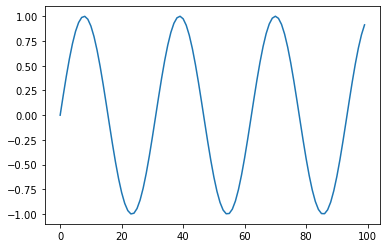

In [7]:
# Testing matplotlib interactions with a simple plot
fig = plt.figure()
plt.plot(np.sin(np.linspace(0, 20, 100)));

In [8]:
%%html
<style>
.old_preview{
    width:auto;
    background-color:rgb(220,220,220);
}
</style>

In [9]:


class Preview():

  #method called update are called if a cell is a sub of another value
  def update(self):
        
    ## change background color of the cell    
  
    if value_options['is_changed']==True:
        self.comp.add_class('old_preview') 
    else:
        for k in list(self.slider_values.keys()) + list(self.dropdown_values.keys()):
         for l in self.labels:
          if k == l['l_f']:
           if k in self.slider_values.keys():
            l['widget'].value = str(k) + ': ' + str(self.slider_values[k])
           else:
            l['widget'].value = str(k) + ': ' + str(self.dropdown_values[k])  
  
        
        self.comp.remove_class('old_preview') 

  def __init__(self,slider_values,dropdown_values):

    
   self.slider_values = slider_values
   self.dropdown_values=dropdown_values
   self.labels=list()
   self.comp=None
   #self.update()
   
   
   for k in self.slider_values.keys():
    f = dict()
    f['l_f'] = k
    f['widget'] = widgets.Label(value=str(k) + ': ' + str(self.slider_values[k]))
    self.labels.append(f)

   for k in self.dropdown_values.keys():
    f = dict()
    f['l_f'] = k
    f['widget'] = widgets.Label(value=str(k) + ': ' + str(self.dropdown_values[k]))
    self.labels.append(f) 
   
  def compose(self):
   rows = [widgets.Label(value='Dati Paziente:')]
   
   for l in self.labels:
     rows.append(l['widget'])
     
   self.comp =  widgets.Box([space(),
                       widgets.VBox(rows,layout=widgets.Layout(display="flex", justify_content="center")),
                       space()],
                      layout=widgets.Layout(border='1px solid grey'))
   return self.comp.add_class('old_preview')    
  
#############################################################################################        
p = Preview(slider_values,dropdown_values)
subscribe(p,sub_dashboard)
subscribe(p,sub_pred)
see(p)   


In [10]:
%matplotlib widget
class Output():
    #is changed == True -> dashboard values has changed 
    #is changed == False -> send button has been pressed and dashboard values has not changed
  def update(self):
    if value_options['is_changed']==False:
     self.compose()   
     if value_options['pred'][0] == 1:
      self.output.value = self.res[True]
     else:
      self.output.value = self.res[False]
     self.comp.remove_class('old_preview') 
     display(refresh_pie())   
    else:
     self.comp.add_class('old_preview')   
   
    
  def __init__(self):
    self.output = widgets.Label(value='')
    self.res ={False: 'Alta probabilità di guarigione', 
               True: 'Bassa probabilità di guarigione'}
    self.comp=None
    
  def compose(self):
     self.comp= widgets.Box([self.output],layout=widgets.Layout(border='1px solid grey'))
     return self.comp.add_class('old_preview')
    ##TODO grafo a torta quando ci saranno i dati
    
#################################################################################   
out = Output()
subscribe(out,sub_pred)
subscribe(out,sub_dashboard)
see(out)

In [11]:
%matplotlib inline
#def refresh_pie():
        
class Pie():
   def update(self):
    refresh_pie()
#btn.on_click(on_click_fn)
def refresh_pie():
 fig = plt.figure()  
 plt.pie(value_options['pred'][1][0], explode=[0.1,0.1], labels=['vivo','morto'], autopct='%1.1f%%',shadow=True, startangle=90)      

    
#############################

k = Pie()
subscribe(k,sub_pred)
#refresh_pie()

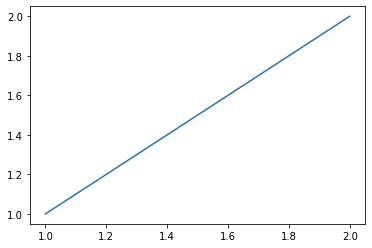

In [34]:
%matplotlib inline

from matplotlib.pyplot import *

button = widgets.Button(description="Button")
out = widgets.Output()

def on_button_clicked(b):
    with out:
        clear_output(True)
        plot([1,2],[2,1])
        show()

button.on_click(on_button_clicked)



with out:
    plot([1,2],[1,2])
#    show()

b= widgets.VBox([button,out])
display(b)

# Nuova sezione

In [12]:
#install https://github.com/matplotlib/ipympl lead instruction

#jupyter labextension install jupyterlab-plotly